# Train a MLP on the BERT embeddings

In [1]:
from data import load_sequences

from tqdm import tqdm
import numpy as np
import csv
import pickle
import copy


import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### 1: Load Data, load embeddings, split train-val

In [2]:
def load_BERT_embedding(path):
    embeddings = pickle.load(open(path, 'rb'))
    for i in range(len(embeddings['Amino Acids'])):
        embeddings['Amino Acids'][i] = embeddings['Amino Acids'][i][1:-1]
    return embeddings['Amino Acids'], embeddings['Protein']

In [15]:
# Sequence data
sequences_train, sequences_test, proteins_test, y_train = load_sequences()


_, embeddings_train = load_BERT_embedding(path='data/bert_fine_tuned_embeddings/train/embeddings.pkl')
_, embeddings_test = load_BERT_embedding(path='data/bert_fine_tuned_embeddings/test/embeddings.pkl')

In [16]:
class proteins_dataset(Dataset):
    def __init__(self, embeddings, labels=None, train=False):
        self.embeddings = embeddings
        self.labels = labels
        self.train = train
    def __len__(self):
        return len(self.embeddings)
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.embeddings[idx])
        if self.train:
            return x, self.labels[idx]
        else:
            return x

In [17]:
dataset_train = proteins_dataset(embeddings_train, y_train, train=True)
dataset_test = proteins_dataset(embeddings_test, train=False)

In [18]:
num_train = int(0.8 * len(dataset_train))
num_val = len(dataset_train) - num_train

train_set, val_set = torch.utils.data.random_split(dataset_train, [num_train, num_val],
                                                   generator=torch.Generator().manual_seed(42))

In [19]:
batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

#### T-sne visualization of the embeddings

In [21]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X = np.array(embeddings_train)
X_tsne = TSNE(n_components=2).fit_transform(X)

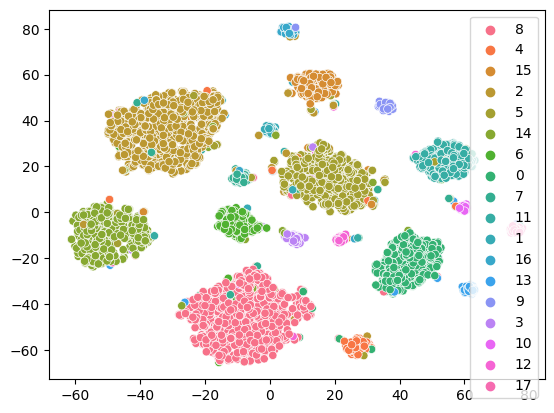

In [22]:
y = np.array(y_train, dtype=str)
import seaborn as sns
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y)
plt.show()

#### Baseline: linear logistic regression

In [23]:
from sklearn.linear_model import LogisticRegression

X_train = np.array(embeddings_train)
X_test = np.array(embeddings_test)

clf = LogisticRegression(solver='liblinear')
clf.fit(X_train, y_train) 
y_pred_proba = clf.predict_proba(X_test)

In [26]:
# Write predictions to a file
with open('submissions/BERT_protein.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list()
    for i in range(18):
        lst.append('class'+str(i))
    lst.insert(0, "name")
    writer.writerow(lst)
    for i, protein in enumerate(proteins_test):
        lst = y_pred_proba[i,:].tolist()
        lst.insert(0, protein)
        writer.writerow(lst)


###  Training and evaluation loops

In [27]:
def evaluate_accuracy(data_loader, verbose=True):
    model.eval()
    total_loss = 0.0
    ncorrect = ntotal = 0
    with torch.no_grad():
        for img, target in data_loader:
            # inference
            output = model(img.to(device))
            # total number of examples
            ntotal +=  output.shape[0]
            # number of correct predictions 
            _, predictions = torch.max(output, 1)
            #print('predictions: ', predictions)
            label = target.to(device)
            #print('Truth: ', label)
            ncorrect += torch.sum(predictions==label)
        acc = ncorrect.item() / ntotal
        if verbose:
          print("validation accuracy: {:3.2f}".format(acc*100))
        return acc

In [28]:
def train():
    best_validation_acc = 0.0
    p = 0 # patience
    
    for epoch in range(1, nb_epochs + 1):
        losses = []
        accuracies = []
        with tqdm(train_loader, unit='batch') as tepoch:
            for img, target in tepoch:
                tepoch.set_description(f"Epoch {epoch}")
                model.train()
                optimizer.zero_grad()
                data = img.to(device)
                label = target.to(device)
                output = model.forward(data)
                loss = criterion(output, label)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
                optimizer.step()
                
                losses.append(loss.item())
                _, predictions = torch.max(output, 1)
                accuracy = torch.sum(predictions == label).item() / batch_size
                accuracies.append(accuracy)
                tepoch.set_postfix(loss=sum(losses)/len(losses), accuracy=100. * sum(accuracies)/len(accuracies))
        train_acc = evaluate_accuracy(train_loader, False)
        val_acc = evaluate_accuracy(val_loader, False)
        print("===> Epoch {} Complete: Avg. Loss: {:.4f}, Validation Accuracy: {:3.2f}%"
              .format(epoch, sum(losses)/len(losses), 100.*val_acc))
        torch.save(model.state_dict(), './model_epoch_{}.pt'.format(epoch))
        if val_acc >= best_validation_acc:
            best_validation_acc = val_acc
            print("Validation accuracy improved, saving model...")
            torch.save(model.state_dict(), './best_model.pt')
            p = 0
            print()
        else:
            p += 1
            if p==my_patience:
                print("Validation accuracy did not improve for {} epochs, stopping training...".format(my_patience))
                break
        scheduler.step()
    print("Loading best checkpoint...")
    last_model = copy.deepcopy(model)
    model.load_state_dict(torch.load('./best_model.pt'))
    model.eval()
    print('done.')
    return last_model

### Define the model architecture

In [40]:
model = nn.Sequential(nn.Linear(1024, 256),
                         nn.ReLU(),
                         nn.Dropout(0.6),
                         nn.Linear(256, 18),
                         nn.LogSoftmax())

model = model.to(device)

### Train the model

In [42]:
lr= 0.01
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
nb_epochs = 35
my_patience=15

last_model = train()

Epoch 1: 100%|███████████████████████████████████████████| 123/123 [00:01<00:00, 76.72batch/s, accuracy=98.7, loss=13.5]


===> Epoch 1 Complete: Avg. Loss: 13.5467, Validation Accuracy: 80.06%
Validation accuracy improved, saving model...



Epoch 2: 100%|███████████████████████████████████████████| 123/123 [00:01<00:00, 77.95batch/s, accuracy=98.5, loss=15.2]


===> Epoch 2 Complete: Avg. Loss: 15.1952, Validation Accuracy: 79.96%


Epoch 3: 100%|███████████████████████████████████████████| 123/123 [00:01<00:00, 77.79batch/s, accuracy=98.8, loss=7.37]


===> Epoch 3 Complete: Avg. Loss: 7.3733, Validation Accuracy: 79.75%


Epoch 4: 100%|███████████████████████████████████████████| 123/123 [00:01<00:00, 77.46batch/s, accuracy=98.8, loss=10.5]


===> Epoch 4 Complete: Avg. Loss: 10.5056, Validation Accuracy: 80.37%
Validation accuracy improved, saving model...



Epoch 5: 100%|███████████████████████████████████████████| 123/123 [00:01<00:00, 90.25batch/s, accuracy=98.8, loss=6.85]


===> Epoch 5 Complete: Avg. Loss: 6.8505, Validation Accuracy: 80.37%
Validation accuracy improved, saving model...



Epoch 6: 100%|███████████████████████████████████████████| 123/123 [00:01<00:00, 91.35batch/s, accuracy=98.9, loss=4.84]


===> Epoch 6 Complete: Avg. Loss: 4.8381, Validation Accuracy: 80.16%


Epoch 7: 100%|█████████████████████████████████████████████| 123/123 [00:01<00:00, 91.52batch/s, accuracy=99, loss=2.04]


===> Epoch 7 Complete: Avg. Loss: 2.0365, Validation Accuracy: 80.06%


Epoch 8: 100%|███████████████████████████████████████████| 123/123 [00:01<00:00, 91.23batch/s, accuracy=99.2, loss=1.86]


===> Epoch 8 Complete: Avg. Loss: 1.8559, Validation Accuracy: 80.06%


Epoch 9: 100%|███████████████████████████████████████████| 123/123 [00:01<00:00, 91.76batch/s, accuracy=99.1, loss=3.88]


===> Epoch 9 Complete: Avg. Loss: 3.8782, Validation Accuracy: 80.06%


Epoch 10: 100%|████████████████████████████████████████████| 123/123 [00:01<00:00, 91.31batch/s, accuracy=99, loss=3.08]


===> Epoch 10 Complete: Avg. Loss: 3.0791, Validation Accuracy: 79.96%


Epoch 11: 100%|████████████████████████████████████████████| 123/123 [00:01<00:00, 91.49batch/s, accuracy=99, loss=3.35]


===> Epoch 11 Complete: Avg. Loss: 3.3548, Validation Accuracy: 79.96%


Epoch 12: 100%|███████████████████████████████████████████| 123/123 [00:01<00:00, 91.14batch/s, accuracy=99.1, loss=2.6]


===> Epoch 12 Complete: Avg. Loss: 2.5955, Validation Accuracy: 79.96%


Epoch 13: 100%|██████████████████████████████████████████| 123/123 [00:01<00:00, 91.20batch/s, accuracy=99.2, loss=1.14]


===> Epoch 13 Complete: Avg. Loss: 1.1411, Validation Accuracy: 79.96%


Epoch 14: 100%|██████████████████████████████████████████| 123/123 [00:01<00:00, 91.21batch/s, accuracy=99.1, loss=3.57]


===> Epoch 14 Complete: Avg. Loss: 3.5711, Validation Accuracy: 79.96%


Epoch 15: 100%|██████████████████████████████████████████| 123/123 [00:01<00:00, 91.25batch/s, accuracy=99.1, loss=2.94]


===> Epoch 15 Complete: Avg. Loss: 2.9392, Validation Accuracy: 79.96%


Epoch 16: 100%|███████████████████████████████████████████| 123/123 [00:01<00:00, 91.39batch/s, accuracy=99.2, loss=2.4]


===> Epoch 16 Complete: Avg. Loss: 2.4000, Validation Accuracy: 79.96%


Epoch 17: 100%|██████████████████████████████████████████| 123/123 [00:01<00:00, 91.19batch/s, accuracy=99.1, loss=1.25]


===> Epoch 17 Complete: Avg. Loss: 1.2525, Validation Accuracy: 79.96%


Epoch 18: 100%|██████████████████████████████████████████| 123/123 [00:01<00:00, 91.68batch/s, accuracy=98.9, loss=4.96]


===> Epoch 18 Complete: Avg. Loss: 4.9639, Validation Accuracy: 79.96%


Epoch 19: 100%|██████████████████████████████████████████| 123/123 [00:01<00:00, 92.57batch/s, accuracy=99.1, loss=2.68]


===> Epoch 19 Complete: Avg. Loss: 2.6839, Validation Accuracy: 79.96%


Epoch 20: 100%|██████████████████████████████████████████| 123/123 [00:01<00:00, 92.70batch/s, accuracy=99.2, loss=1.35]


===> Epoch 20 Complete: Avg. Loss: 1.3457, Validation Accuracy: 79.96%
Validation accuracy did not improve for 15 epochs, stopping training...
Loading best checkpoint...
done.


In [39]:
path_submission = 'submissions/MLP_bert_2.csv'
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=False)
model.eval()
preds = list()
with torch.no_grad():
    for batch in tqdm(test_loader):
        x = batch.to(device)
        out = model(x)
        pred = out.detach().cpu().numpy()
        pred = np.exp(pred)
        preds.append(pred)
y_pred_proba = np.array([list(pred[0]) for pred in preds])

print("Writing submissions to : {}".format(path_submission))
with open(path_submission, 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list()
    for i in range(18):
        lst.append('class' + str(i))
    lst.insert(0, "name")
    writer.writerow(lst)
    for i, protein in enumerate(proteins_test):
        lst = y_pred_proba[i, :].tolist()
        lst.insert(0, protein)
        writer.writerow(lst)

100%|█████████████████████████████████████████████████████████████████████████████| 1223/1223 [00:00<00:00, 2821.32it/s]

Writing submissions to : submissions/MLP_bert_2.csv
